# 04__activities
# analyzing activity levels per element (neg ctrls; between biotypes)

in this notebook, i perform analyses examining the activities of reference tiles in both pool1 and pool2. i compare reference sequences to negative controls, examine reference activities between biotypes, examine how MPRA activity compares to CAGE expression, and determine how many sequences are expressed across cell types.

------

figures in this notebook:
- **Fig 2B, Fig S8A, Fig S12**: boxplots comparing reference sequences to negative controls
- **Fig 2C, Fig S8B**: boxplots comparing activities between biotypes
- **Fig 2D**: KDE plot comparing CAGE cell type specificity and MPRA cell type specificity
- **Fig 2E**: barplot showing % of reference sequences active in 1 or all 3 cell types

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from scipy import stats
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
activ_dir = "../../data/02__activs"
pval_dir = "../../data/03__pvals"
index_dir = "../../data/00__index"

In [4]:
pool1_hela_barc_activ_f = "POOL1__pMPRA1__HeLa__activities_per_barcode.txt"
pool1_hepg2_barc_activ_f = "POOL1__pMPRA1__HepG2__activities_per_barcode.txt"
pool1_k562_barc_activ_f = "POOL1__pMPRA1__K562__activities_per_barcode.txt"

pool1_hela_elem_activ_f = "POOL1__pMPRA1__HeLa__activities_per_element.txt"
pool1_hepg2_elem_activ_f = "POOL1__pMPRA1__HepG2__activities_per_element.txt"
pool1_k562_elem_activ_f = "POOL1__pMPRA1__K562__activities_per_element.txt"

pool1_hela_pvals_f = "POOL1__pMPRA1__HeLa__pvals.txt"
pool1_hepg2_pvals_f = "POOL1__pMPRA1__HepG2__pvals.txt"
pool1_k562_pvals_f = "POOL1__pMPRA1__K562__pvals.txt"

In [5]:
pool1_nocmv_hela_barc_activ_f = "POOL1__pNoCMVMPRA1__HeLa__activities_per_barcode.txt"
pool1_nocmv_hepg2_barc_activ_f = "POOL1__pNoCMVMPRA1__HepG2__activities_per_barcode.txt"
pool1_nocmv_k562_barc_activ_f = "POOL1__pNoCMVMPRA1__K562__activities_per_barcode.txt"

pool1_nocmv_hela_elem_activ_f = "POOL1__pNoCMVMPRA1__HeLa__activities_per_element.txt"
pool1_nocmv_hepg2_elem_activ_f = "POOL1__pNoCMVMPRA1__HepG2__activities_per_element.txt"
pool1_nocmv_k562_elem_activ_f = "POOL1__pNoCMVMPRA1__K562__activities_per_element.txt"

pool1_nocmv_hela_pvals_f = "POOL1__pNoCMVMPRA1__HeLa__pvals.txt"
pool1_nocmv_hepg2_pvals_f = "POOL1__pNoCMVMPRA1__HepG2__pvals.txt"
pool1_nocmv_k562_pvals_f = "POOL1__pNoCMVMPRA1__K562__pvals.txt"

In [6]:
pool2_hepg2_barc_activ_f = "POOL2__pMPRA1__HepG2__activities_per_barcode.txt"
pool2_k562_barc_activ_f = "POOL2__pMPRA1__K562__activities_per_barcode.txt"

pool2_hepg2_elem_activ_f = "POOL2__pMPRA1__HepG2__activities_per_element.txt"
pool2_k562_elem_activ_f = "POOL2__pMPRA1__K562__activities_per_element.txt"

pool2_hepg2_pvals_f = "POOL2__pMPRA1__HepG2__pvals.txt"
pool2_k562_pvals_f = "POOL2__pMPRA1__K562__pvals.txt"

In [7]:
pool1_index_f = "%s/tss_oligo_pool.index.txt" % index_dir
pool2_index_f = "%s/dels_oligo_pool.index.txt" % index_dir

In [8]:
annot_f = "../../misc/00__tss_properties/correspondance_seqID_PromType_unique.txt"
id_map_f = "../../misc/00__tss_properties/TABLE_ALL_TSS_and_flipped.properties.PromType.txt"

## 1. import data

In [9]:
pool1_index = pd.read_table(pool1_index_f, sep="\t")
pool2_index = pd.read_table(pool2_index_f, sep="\t")

In [10]:
pool1_index_elem = pool1_index[["element", "oligo_type", "unique_id", "dupe_info", "SNP"]]
pool2_index_elem = pool2_index[["element", "oligo_type", "unique_id", "dupe_info", "SNP"]]

pool1_index_elem = pool1_index_elem.drop_duplicates()
pool2_index_elem = pool2_index_elem.drop_duplicates()

In [11]:
annot = pd.read_table(annot_f, sep="\t")
annot.head()

,seqID,PromType2
0,WILDTYPE__Antisense.noflip.NA__chr1:100435456....,div_lnc
1,WILDTYPE__Lincrna.flip.sense__chr1:100731637.....,div_lnc
2,FLIPPED__Lincrna.flip.antisense__chr1:10073163...,div_lnc
3,FLIPPED__mrna.flip.antisense__chr1:100731714.....,div_pc
4,WILDTYPE__mrna.flip.sense__chr1:100731714..100...,div_pc


In [12]:
id_map = pd.read_table(id_map_f, sep="\t")
id_map.head()

,gene_id,TSS_associated_1st.transc_id,oligo_reg,TSS_id,TSS_description,TSS_transc_association,avExpALL,gene_name,gene_type,GeneType,...,rs.SNP1,rs.SNP2,R.squared,Distance,trait,n.eQTLs,n.eQTLs94,PromType,PromType2,PromType3
0,ENSG00000000419.8,ENST00000371583,"chr20:49575034..49575148,-","chr20:49575059..49575077,-",p1@DPM1,"0bp_to_ENST00000371583,ENST00000413082,ENST000...",71.110566,DPM1,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
1,ENSG00000002586.13,ENST00000381187,"chrX:2609217..2609331,+","chrX:2609278..2609302,+",p3@CD99,-14bp_to_ENST00000381187_5end,17.394880,CD99,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
2,ENSG00000002919.10,ENST00000359238,"chr17:46184858..46184972,+","chr17:46184920..46184951,+",p2@SNX11,"0bp_to_ENST00000359238,ENST00000393405,ENST000...",4.722549,SNX11,protein_coding,protein_coding,...,rs72823592,rs16952265,0.844249196799263,-61879,Epilepsy_(generalized),2,2,protein_coding,protein_coding,protein_coding
3,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,-","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
4,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,+","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding


### pool 1

In [13]:
pool1_hela_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hela_elem_activ_f), sep="\t")
pool1_hepg2_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hepg2_elem_activ_f), sep="\t")
pool1_k562_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_k562_elem_activ_f), sep="\t")
pool1_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,-1.229482,-1.201427,-1.207830,-1.138838
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,-0.264065,-0.260860,-0.300284,-0.182098
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,-0.534859,-0.557712,-0.578824,-0.754250
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,-1.250940,-1.065514,-1.058389,-1.399819
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,0.180815,0.251183,0.186228,0.145362


In [14]:
pool1_hela_reps = [x for x in pool1_hela_elem_norm.columns if "rna_" in x]
pool1_hepg2_reps = [x for x in pool1_hepg2_elem_norm.columns if "rna_" in x]
pool1_k562_reps = [x for x in pool1_k562_elem_norm.columns if "rna_" in x]
pool1_hepg2_reps

['rna_3',
 'rna_4',
 'rna_5',
 'rna_6',
 'rna_7',
 'rna_8',
 'rna_9',
 'rna_10',
 'rna_11',
 'rna_12',
 'rna_13',
 'rna_14']

In [15]:
pool1_hela_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hela_barc_activ_f), sep="\t")
pool1_hepg2_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hepg2_barc_activ_f), sep="\t")
pool1_k562_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_k562_barc_activ_f), sep="\t")
pool1_hepg2_barc_norm.head()

,barcode,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14
0,AAAACAAAGTC,-0.232915,-0.409743,-0.830252,-0.558582,0.259745,0.471566,0.137889,0.605610,-0.115982,0.389549,0.251261,0.360733
1,AAAACAAAGTT,-1.641943,-1.786002,NaN,NaN,NaN,-1.472057,-2.748240,0.123337,-3.569422,-0.959375,-2.188633,-1.877116
2,AAAACAAATGT,0.445553,0.331374,0.022147,-0.308519,0.782481,0.935864,0.411982,0.688970,0.972243,0.836551,0.892322,0.819801
3,AAAACAACGTC,-0.010666,1.834886,1.047326,-0.196539,0.456452,0.568126,0.930430,1.951003,0.654473,1.429290,2.026544,1.170410
4,AAAACAACGTG,0.339223,0.864835,-1.879958,-0.186074,0.235210,-1.084751,1.190649,1.043910,-1.136628,0.028256,0.408414,0.148594


In [16]:
pool1_hela_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_hela_pvals_f), sep="\t")
pool1_hepg2_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_hepg2_pvals_f), sep="\t")
pool1_k562_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_k562_pvals_f), sep="\t")
pool1_hepg2_pvals.head()

,unique_id,element,oligo_type,rna_3_log2fc,rna_4_log2fc,rna_5_log2fc,rna_6_log2fc,rna_7_log2fc,rna_8_log2fc,rna_9_log2fc,...,rna_10_padj,rna_11_padj,rna_12_padj,rna_13_padj,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,CONTROL_BUT_HAS_SNP,0.403405,0.330523,0.485259,0.487744,0.419931,0.289986,0.127793,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,CONTROL_BUT_HAS_SNP,1.146015,0.949856,1.324285,1.245177,1.331950,1.112834,0.963992,...,1.043711e-04,4.644729e-17,3.492436e-17,1.681772e-17,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,CONTROL_BUT_HAS_SNP,0.654683,0.618780,0.782989,0.782589,0.857763,0.969354,0.618092,...,3.011102e-07,2.598576e-07,4.289247e-11,2.666966e-08,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,CONTROL_BUT_HAS_SNP,0.344792,0.375084,0.052049,0.452240,0.243133,0.199732,0.396825,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,CONTROL_BUT_HAS_SNP,1.574229,1.580879,1.730772,1.652956,1.637522,1.661432,1.461112,...,5.031197e-27,3.273184e-31,5.153033e-31,7.265345e-30,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active


### pool 2

In [17]:
pool2_hepg2_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool2_hepg2_elem_activ_f), sep="\t")
pool2_k562_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool2_k562_elem_activ_f), sep="\t")
pool2_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.790824,-1.506121,-1.253360,-1.425010,-1.616346,-1.290745,-1.357850,-1.364172
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,-0.501004
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,-1.210300,-1.264010,-1.127320,-1.101221,-1.304477,-1.178312,-1.065390,-1.429695
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.469084,0.792547,0.496125,0.538051,0.669531,0.552507,0.692894,0.565142
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.703193,-1.657239,-1.342610,-1.407414,-1.560008,-1.441266,-1.275676,-1.331183


In [18]:
pool2_hepg2_reps = [x for x in pool2_hepg2_elem_norm.columns if "rna_" in x]
pool2_k562_reps = [x for x in pool2_k562_elem_norm.columns if "rna_" in x]
pool2_hepg2_reps

['rna_3', 'rna_4', 'rna_5', 'rna_6', 'rna_7', 'rna_8', 'rna_9', 'rna_10']

In [19]:
pool2_hepg2_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool2_hepg2_barc_activ_f), sep="\t")
pool2_k562_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool2_k562_barc_activ_f), sep="\t")
pool2_hepg2_barc_norm.head()

,barcode,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,AAAACAAAGTC,NaN,NaN,0.559995,NaN,NaN,NaN,NaN,NaN
1,AAAACAACGTG,-1.780485,-0.598085,-1.170739,-0.878212,-1.162959,-1.45008,-0.133118,-1.089508
2,AAAACAACTGG,NaN,NaN,-2.425661,NaN,NaN,NaN,NaN,NaN
3,AAAACAAGATG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAACAAGATT,-1.028853,-1.208253,-3.278023,NaN,-2.543835,-4.28303,-1.792000,-0.798199


In [20]:
pool2_hepg2_pvals = pd.read_table("%s/%s" % (pval_dir, pool2_hepg2_pvals_f), sep="\t")
pool2_k562_pvals = pd.read_table("%s/%s" % (pval_dir, pool2_k562_pvals_f), sep="\t")
pool2_hepg2_pvals.head()

,unique_id,element,oligo_type,rna_3_log2fc,rna_4_log2fc,rna_5_log2fc,rna_6_log2fc,rna_7_log2fc,rna_8_log2fc,rna_9_log2fc,...,rna_6_padj,rna_7_padj,rna_8_padj,rna_9_padj,rna_10_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,CONTROL_BUT_HAS_SNP,-0.740530,-0.483852,-0.266400,-0.420682,-0.565798,-0.276644,-0.338944,...,5.301211e-02,9.182491e-06,9.165985e-01,2.859277e-01,1.000000e+00,1.653376e-23,sig,not sig,sig,sig repressive
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,CONTROL_BUT_HAS_SNP,0.395869,0.428595,0.382347,0.279643,0.291139,0.361236,0.427300,...,1.000000e+00,1.000000e+00,1.552552e-01,2.618122e-02,1.545699e-03,2.506378e-15,sig,not sig,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,CONTROL_BUT_HAS_SNP,-0.160006,-0.241741,-0.140360,-0.096893,-0.253929,-0.164211,-0.046484,...,1.000000e+00,5.887921e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,not sig,not sig,not sig,not sig
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,CONTROL_BUT_HAS_SNP,1.519378,1.814816,1.483085,1.542379,1.720079,1.566608,1.711800,...,9.008623e-25,3.404805e-34,3.490157e-28,2.103572e-30,2.605472e-31,2.232976e-230,sig,sig active,sig,sig active
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,CONTROL_SNP_INDIV,-0.652900,-0.634970,-0.355650,-0.403086,-0.509460,-0.427165,-0.256770,...,1.095963e-01,8.470045e-04,3.288456e-01,5.823235e-01,1.000000e+00,7.097918e-23,sig,not sig,sig,sig repressive


## 2. merge with index

### pool 1

In [21]:
pool1_hela_elem_norm = pool1_hela_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm = pool1_hepg2_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")
pool1_k562_elem_norm = pool1_k562_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")

In [22]:
pool1_hela_barc_norm = pool1_hela_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")
pool1_hepg2_barc_norm = pool1_hepg2_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")
pool1_k562_barc_norm = pool1_k562_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")

In [23]:
pool1_hela_elem_norm["better_type"] = pool1_hela_elem_norm.apply(better_type, axis=1)
pool1_hepg2_elem_norm["better_type"] = pool1_hepg2_elem_norm.apply(better_type, axis=1)
pool1_k562_elem_norm["better_type"] = pool1_k562_elem_norm.apply(better_type, axis=1)

In [24]:
pool1_hela_elem_norm = pool1_hela_elem_norm.merge(pool1_hela_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm = pool1_hepg2_elem_norm.merge(pool1_hepg2_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_k562_elem_norm = pool1_k562_elem_norm.merge(pool1_k562_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_10_padj,rna_11_padj,rna_12_padj,rna_13_padj,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,1.043711e-04,4.644729e-17,3.492436e-17,1.681772e-17,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,3.011102e-07,2.598576e-07,4.289247e-11,2.666966e-08,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,5.031197e-27,3.273184e-31,5.153033e-31,7.265345e-30,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active


### pool 2

In [25]:
pool2_hepg2_elem_norm = pool2_hepg2_elem_norm.merge(pool2_index_elem, on=["unique_id", "element"], how="left")
pool2_k562_elem_norm = pool2_k562_elem_norm.merge(pool2_index_elem, on=["unique_id", "element"], how="left")

In [26]:
pool2_hepg2_barc_norm = pool2_hepg2_barc_norm.merge(pool2_index, left_on="barcode", right_on="barcode", how="left")
pool2_k562_barc_norm = pool2_k562_barc_norm.merge(pool2_index, left_on="barcode", right_on="barcode", how="left")

In [27]:
pool2_hepg2_elem_norm["better_type"] = pool2_hepg2_elem_norm.apply(better_type, axis=1)
pool2_k562_elem_norm["better_type"] = pool2_k562_elem_norm.apply(better_type, axis=1)

In [28]:
pool2_hepg2_elem_norm = pool2_hepg2_elem_norm.merge(pool2_hepg2_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool2_k562_elem_norm = pool2_k562_elem_norm.merge(pool2_k562_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool2_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_6_padj,rna_7_padj,rna_8_padj,rna_9_padj,rna_10_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.790824,-1.506121,-1.253360,-1.425010,-1.616346,-1.290745,-1.357850,-1.364172,...,5.301211e-02,9.182491e-06,9.165985e-01,2.859277e-01,1.000000e+00,1.653376e-23,sig,not sig,sig,sig repressive
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,-0.501004,...,1.000000e+00,1.000000e+00,1.552552e-01,2.618122e-02,1.545699e-03,2.506378e-15,sig,not sig,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,-1.210300,-1.264010,-1.127320,-1.101221,-1.304477,-1.178312,-1.065390,-1.429695,...,1.000000e+00,5.887921e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,not sig,not sig,not sig,not sig
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.469084,0.792547,0.496125,0.538051,0.669531,0.552507,0.692894,0.565142,...,9.008623e-25,3.404805e-34,3.490157e-28,2.103572e-30,2.605472e-31,2.232976e-230,sig,sig active,sig,sig active
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.703193,-1.657239,-1.342610,-1.407414,-1.560008,-1.441266,-1.275676,-1.331183,...,1.095963e-01,8.470045e-04,3.288456e-01,5.823235e-01,1.000000e+00,7.097918e-23,sig,not sig,sig,sig repressive


## 3. count significantly active/inactive tiles

### pool 1

In [29]:
pool1_hela_elem_norm["overall_mean"] = pool1_hela_elem_norm[pool1_hela_reps].mean(axis=1)
pool1_hepg2_elem_norm["overall_mean"] = pool1_hepg2_elem_norm[pool1_hepg2_reps].mean(axis=1)
pool1_k562_elem_norm["overall_mean"] = pool1_k562_elem_norm[pool1_k562_reps].mean(axis=1)

pool1_hela_elem_norm["overall_median"] = pool1_hela_elem_norm[pool1_hela_reps].median(axis=1)
pool1_hepg2_elem_norm["overall_median"] = pool1_hepg2_elem_norm[pool1_hepg2_reps].median(axis=1)
pool1_k562_elem_norm["overall_median"] = pool1_k562_elem_norm[pool1_k562_reps].median(axis=1)

In [30]:
for cell, df in zip(["HeLa", "HepG2", "K562"], [pool1_hela_elem_norm, pool1_hepg2_elem_norm, pool1_k562_elem_norm]):
    print("%s: combined class" % cell)
    print(df.combined_class.value_counts())
    print("")
    if cell == "HepG2":
        print("%s: downsampled class" % cell)
        print(df.downsamp_combined_class.value_counts())
        print("")

HeLa: combined class
not sig           6384
sig active         765
sig repressive       3
Name: combined_class, dtype: int64

HepG2: combined class
not sig           4449
sig active        2677
sig repressive      26
Name: combined_class, dtype: int64

HepG2: downsampled class
not sig           4672
sig active        2474
sig repressive       6
Name: downsamp_combined_class, dtype: int64

K562: combined class
not sig           5127
sig active        2013
sig repressive      12
Name: combined_class, dtype: int64



### pool 2

In [31]:
pool2_hepg2_elem_norm["overall_mean"] = pool2_hepg2_elem_norm[pool2_hepg2_reps].mean(axis=1)
pool2_k562_elem_norm["overall_mean"] = pool2_k562_elem_norm[pool2_k562_reps].mean(axis=1)

pool2_hepg2_elem_norm["overall_median"] = pool2_hepg2_elem_norm[pool2_hepg2_reps].median(axis=1)
pool2_k562_elem_norm["overall_median"] = pool2_k562_elem_norm[pool2_k562_reps].median(axis=1)

In [32]:
for cell, df in zip(["HepG2", "K562"], [pool2_hepg2_elem_norm, pool2_k562_elem_norm]):
    print("%s: combined class" % cell)
    print(df.combined_class.value_counts())
    print("")
    if cell == "HepG2":
        print("%s: downsampled class" % cell)
        print(df.downsamp_combined_class.value_counts())
        print("")

HepG2: combined class
not sig           8213
sig active         175
sig repressive       1
Name: combined_class, dtype: int64

HepG2: downsampled class
not sig           8214
sig active         169
sig repressive       6
Name: downsamp_combined_class, dtype: int64

K562: combined class
not sig           8289
sig active          88
sig repressive      12
Name: combined_class, dtype: int64



## 4. boxplots: neg ctrls vs reference

In [33]:
order = ["RANDOM", "SCRAMBLED", "WILDTYPE"]
palette = {"RANDOM": "gray", "SCRAMBLED": "gray", "WILDTYPE": "black"}

### pool 1

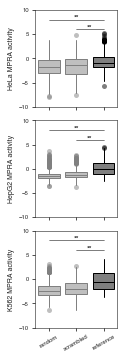

In [34]:
f, axarr = plt.subplots(3, sharex=True, sharey=True, figsize=(1.78, 5))
neg_control_plot(pool1_hela_elem_norm, order, palette, fontsize, "HeLa", axarr[0], None, "HeLa MPRA activity", 
                 True, False, False, None)
neg_control_plot(pool1_hepg2_elem_norm, order, palette, fontsize, "HepG2", axarr[1], None, "HepG2 MPRA activity", 
                 True, False, False, None)
neg_control_plot(pool1_k562_elem_norm, order, palette, fontsize, "K562", axarr[2], None, "K562 MPRA activity", 
                 True, False, False, None)
plt.tight_layout()
f.savefig("Fig_2B_S8A.pdf", bbox_inches="tight", dpi="figure")

### pool 2

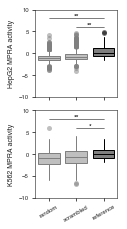

In [35]:
f, axarr = plt.subplots(2, sharex=True, sharey=True, figsize=(1.78, 3.2))
neg_control_plot(pool2_hepg2_elem_norm, order, palette, fontsize, "HepG2", axarr[0], None, "HepG2 MPRA activity", 
                 True, False, False, None)
neg_control_plot(pool2_k562_elem_norm, order, palette, fontsize, "K562", axarr[1], None, "K562 MPRA activity", 
                 True, False, False, None)
plt.tight_layout()
f.savefig("Fig_S12.pdf", bbox_inches="tight", dpi="figure")

## 5. boxplots: across TSS classes

the rest of the analysis only uses pool 1 (the TSS pool), as it looks at patterns in expression differences between TSS classes

In [36]:
pool1_hepg2_df = pool1_hepg2_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_hela_df = pool1_hela_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_k562_df = pool1_k562_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_hepg2_df.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig,-1.108018,-1.104777,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,protein_coding
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active,-0.299548,-0.267746,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,control
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active,-0.647109,-0.657756,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig,-1.166325,-1.144993,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active,0.184302,0.187157,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,protein_coding


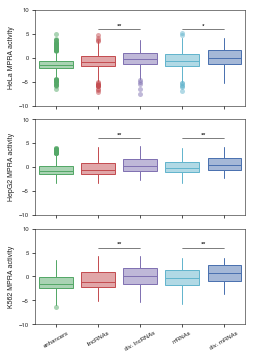

In [37]:
f, axarr = plt.subplots(3, sharex=True, sharey=True, figsize=(3.56, 5))
promtype_plot(pool1_hela_df, TSS_CLASS_ORDER, TSS_CLASS_PALETTE, fontsize, "HeLa", axarr[0], None, 
              "HeLa MPRA activity", True, False, False, None)
promtype_plot(pool1_hepg2_df, TSS_CLASS_ORDER, TSS_CLASS_PALETTE, fontsize, "HepG2", axarr[1], None, 
              "HepG2 MPRA activity", True, False, False, None)
promtype_plot(pool1_k562_df, TSS_CLASS_ORDER, TSS_CLASS_PALETTE, fontsize, "K562", axarr[2], None, 
              "K562 MPRA activity", True, False, False, None)
plt.tight_layout()
f.savefig("Fig_2C_S8B.pdf", bbox_inches="tight", dpi="figure")

## 6. barplots: find % of sequences active across cell types

In [38]:
pool1_hela_df["cell"] = "HeLa"
pool1_hepg2_df["cell"] = "HepG2"
pool1_k562_df["cell"] = "K562"

all_df = pool1_hela_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]].append(pool1_hepg2_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]]).append(pool1_k562_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]])

In [39]:
df = all_df[all_df["better_type"] == "WILDTYPE"]
activ_grp = df.groupby("unique_id")["cell", "combined_class"].agg(lambda x: list(x)).reset_index()
activ_grp = activ_grp.merge(annot, left_on="unique_id", right_on="seqID", how="left").drop("seqID", axis=1)
activ_grp = activ_grp[(activ_grp["PromType2"].isin(TSS_CLASS_ORDER)) & 
                      ~(activ_grp["unique_id"].str.contains("SCRAMBLED"))]
activ_grp.sample(10)

,unique_id,cell,combined_class,PromType2
1938,WILDTYPE__mrna.flip.sense__chr15:40331342..403...,"[HeLa, HepG2, K562]","[sig active, sig active, sig active]",div_pc
750,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr17:61...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",protein_coding
752,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr17:74...,"[HeLa, HepG2, K562]","[sig active, sig active, sig active]",protein_coding
94,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",intergenic
293,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",Enhancer
232,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,"[HeLa, HepG2, K562]","[sig active, sig active, sig active]",Enhancer
534,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr7:...,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",div_lnc
1777,WILDTYPE__Lincrna.noflip.NA__chr21:17791803..1...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",intergenic
843,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr2:177...,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",div_pc
1462,WILDTYPE__Enhancer.noflip.NA__chr17:68310793.....,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",Enhancer


In [40]:
activ_grp["active_in_only_one"] = activ_grp.apply(active_in_only_one, axis=1)
activ_grp["active_in_only_two"] = activ_grp.apply(active_in_only_two, axis=1)
activ_grp["active_in_only_three"] = activ_grp.apply(active_in_only_three, axis=1)
activ_grp.sample(5)

,unique_id,cell,combined_class,PromType2,active_in_only_one,active_in_only_two,active_in_only_three
2140,WILDTYPE__mrna.noflip.NA__chr2:145277651..1452...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",protein_coding,False,False,False
1798,WILDTYPE__Lincrna.noflip.NA__chr2:208104288..2...,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",intergenic,True,False,False
2036,WILDTYPE__mrna.noflip.NA__chr11:124670529..124...,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",div_pc,True,False,False
1773,WILDTYPE__Lincrna.noflip.NA__chr20:57090475..5...,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",div_lnc,False,True,False
1403,WILDTYPE__Enhancer.noflip.NA__chr11:72449313.....,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",Enhancer,False,True,False


In [41]:
activ_counts_1 = activ_grp.groupby(["PromType2", "active_in_only_one"])["unique_id"].agg("count").reset_index()
activ_pcts_1 = activ_counts_1.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_1["percent"] = activ_pcts_1

activ_counts_2 = activ_grp.groupby(["PromType2", "active_in_only_two"])["unique_id"].agg("count").reset_index()
activ_pcts_2 = activ_counts_2.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_2["percent"] = activ_pcts_2

activ_counts_3 = activ_grp.groupby(["PromType2", "active_in_only_three"])["unique_id"].agg("count").reset_index()
activ_pcts_3 = activ_counts_3.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_3["percent"] = activ_pcts_3

activ_counts_1 = activ_counts_1[activ_counts_1["active_in_only_one"]]
activ_counts_2 = activ_counts_2[activ_counts_2["active_in_only_two"]]
activ_counts_3 = activ_counts_3[activ_counts_3["active_in_only_three"]]

activ_counts = activ_counts_1.merge(activ_counts_2, on="PromType2").merge(activ_counts_3, on="PromType2")
activ_counts.drop(["active_in_only_one", "unique_id_x", "active_in_only_two", "unique_id_y", 
                   "active_in_only_three", "unique_id"],
                  axis=1, inplace=True)
activ_counts.columns = ["PromType2", "active_in_only_one", "active_in_only_two", "active_in_only_three"]
activ_counts = pd.melt(activ_counts, id_vars="PromType2")
activ_counts.head()

,PromType2,variable,value
0,Enhancer,active_in_only_one,25.886525
1,div_lnc,active_in_only_one,16.997167
2,div_pc,active_in_only_one,7.299270
3,intergenic,active_in_only_one,18.352941
4,protein_coding,active_in_only_one,16.193656


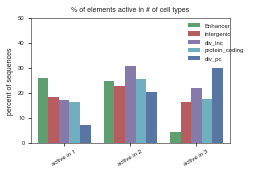

In [42]:
df = activ_counts[activ_counts["PromType2"] != "antisense"]
df["PromType2"] = pd.Categorical(df["PromType2"], TSS_CLASS_ORDER)
df.sort_values(by="PromType2")

plt.figure(figsize=(3.56, 2.3))
ax = sns.barplot(data=df, x="variable", y="value", hue="PromType2", ci=None, palette=TSS_CLASS_PALETTE)
ax.set_xticklabels(["active in 1", "active in 2", "active in 3"], rotation=30)

plt.legend(bbox_to_anchor=(1.1, 1))
plt.ylim((0, 50))
plt.ylabel("percent of sequences", size=fontsize)
plt.xlabel("")
plt.title("% of elements active in # of cell types")

In [43]:
colors = []
for c in TSS_CLASS_ORDER:
    colors.append(TSS_CLASS_PALETTE[c])
colors

[(0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]

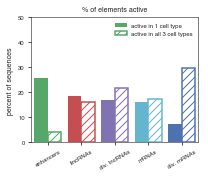

In [44]:
# better plot showing tissue sp
df = activ_counts[activ_counts["PromType2"] != "antisense"]
df["PromType2"] = pd.Categorical(df["PromType2"], TSS_CLASS_ORDER)
df.sort_values(by="PromType2")

plt.figure(figsize=(3,2.3))
ax = sns.barplot(data=df[df["variable"]!="active_in_only_two"], x="PromType2", y="value", 
                 ci=None, hue="variable", linewidth=1.5)
ax.set_xticklabels(["enhancers", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)

colors = colors*2
for i, p in enumerate(ax.patches):
    if i < 5:
        p.set_facecolor(colors[i])
    else:
        p.set_facecolor("white")
        p.set_edgecolor(colors[i])
        p.set_alpha(1)
        p.set_hatch("///")

plt.legend(loc=1, title="", labels=["active in 1 cell type", "active in all 3 cell types"])
plt.ylim((0, 50))
plt.ylabel("percent of sequences", fontsize=fontsize)
plt.xlabel("")
plt.title("% of elements active")
plt.savefig("Fig_2E.pdf", bbox_inches="tight", dpi="figure")

## 7. kdeplot: compare to CAGE

In [45]:
hepg2_activ = pool1_hepg2_df[["unique_id", "element", "better_type", "overall_mean", "PromType2"]]
hela_activ = pool1_hela_df[["unique_id", "element", "better_type", "overall_mean"]]
k562_activ = pool1_k562_df[["unique_id", "element", "better_type", "overall_mean"]]

all_activ = hepg2_activ.merge(hela_activ, on=["unique_id", "element", "better_type"], how="left").merge(k562_activ, on=["unique_id", "element", "better_type"], how="left")
all_activ.columns = ["unique_id", "element", "better_type", "HepG2", "PromType2", "HeLa", "K562"]
all_activ = all_activ[["unique_id", "element", "better_type", "PromType2", "HepG2", "HeLa", "K562"]]
all_activ = all_activ[(all_activ["PromType2"].isin(TSS_CLASS_ORDER)) & 
                      ~(all_activ["unique_id"].str.contains("SCRAMBLED")) &
                      (all_activ["better_type"] == "WILDTYPE")]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562
6793,WILDTYPE__Lincrna.noflip.NA__chr7:130597921..1...,AAATGAATAGCCACAGTTTTTTGGAATGAACGTTGTGAAATCCCTC...,WILDTYPE,intergenic,-1.390236,-3.415184,-3.595706
3321,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,TGATTGGCCCTAAGCTGCGGGCGCCAGTTTTCATTGGGTGAGCGGT...,WILDTYPE,intergenic,0.592479,-1.653564,1.298484
6681,WILDTYPE__Lincrna.noflip.NA__chr1:207996013..2...,TTTTTGATTGGCTCAGGGCAGGGTATCAAATCTGAATTTGCATTTC...,WILDTYPE,intergenic,-1.167448,-1.927046,-2.438955
3875,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr14:24...,AGTCGCGGCCGCCAGCTAGGGGCGCGGGAAGGCGGGGCTCGGATGC...,WILDTYPE,protein_coding,1.378687,2.050981,1.019552
6731,WILDTYPE__Lincrna.noflip.NA__chr2:241195438..2...,GACACATGATCCAAAGGAATGTGTACAATTCCAGGTATGCACAGGC...,WILDTYPE,intergenic,1.104963,-0.329997,-2.286476


In [46]:
all_activ["combined_class"] = ""
all_activ = all_activ.merge(pool1_hela_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_HeLa")).merge(pool1_hepg2_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_HepG2")).merge(pool1_k562_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_K562"))
all_activ.drop("combined_class", axis=1, inplace=True)
all_activ.head()

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GGTGGGCCCCCTCCCCCTTCTTCCGGCGGGCCTCCTCCCTCCCCTT...,WILDTYPE,intergenic,2.688943,-0.470427,1.981653,sig active,sig active,sig active
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GACTAAATAAGGGAGGCTGCAGCGGCTGCGCGTGCGCCCAGAGGCG...,WILDTYPE,div_lnc,-0.701841,0.371693,0.166442,not sig,sig active,not sig
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AACTCGCCCTCCGGAAAGACGCGGGGGAATTCTGGGAGTGCGCGGC...,WILDTYPE,intergenic,1.704007,0.456156,1.976386,sig active,sig active,sig active
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,CACCAACCGCCCCACCGCACCCTGCGCCAGCCCTACGGCGCCCGCG...,WILDTYPE,intergenic,-0.022075,1.114820,-0.701002,not sig,sig active,not sig
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AGACCCACAGGAAATGACGACAGAAGGGCTGAGGTGGGGGGGCGGG...,WILDTYPE,div_lnc,3.759629,2.141635,3.237685,sig active,sig active,sig active


In [47]:
all_activ["oligo_reg"] = all_activ.unique_id.str.split("__", expand=True)[2]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,oligo_reg
661,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr14:10...,GCCCGCCCATTGGCCTCACTCGGCGCCCCCACCCGGGCCCTGCCGG...,WILDTYPE,protein_coding,0.099244,NaN,1.444461,not sig,not sig,not sig,"chr14:100772772..100772886,-"
1524,WILDTYPE__Lincrna.flip.sense__chr8:90769868..9...,CCGAGCTCCTCCCTCCCCAAACTTCGCAGGTTACGTCAGCGGCGGA...,WILDTYPE,div_lnc,0.928082,-1.252549,1.287431,not sig,not sig,not sig,"chr8:90769868..90769982,-"
1069,WILDTYPE__Antisense.noflip.NA__chr20:32580865....,GGAGATGGCGCTCAAATCTGCAGGCTGTGGGCGGTGCAGGAGGGAT...,WILDTYPE,div_lnc,1.349086,0.032770,1.335089,sig active,sig active,sig active,"chr20:32580865..32580979,-"
463,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr4:...,TCTCTGTAAAATGGACCAATCAGCAGGATGTGGGTGGGGCCAGATA...,WILDTYPE,intergenic,1.587634,-1.208265,1.848832,not sig,sig active,sig active,"chr4:31998921..31999035,+"
1195,WILDTYPE__Enhancer.flip.sense__chr1:2509790..2...,GGCTTCGGGCTGCTCAGCTCCTGCCCGTGCCCACTGCAGGAAAAAA...,WILDTYPE,Enhancer,0.353994,-2.739099,-0.235912,not sig,sig active,sig active,"chr1:2509790..2509904,+"


In [48]:
id_map = id_map[["oligo_reg", "K562_rep1", "K562_rep2", "K562_rep3", "HeLa_rep1", "HeLa_rep2", "HeLa_rep3", 
                 "HepG2_rep1", "HepG2_rep2", "HepG2_rep3"]]
all_activ = all_activ.merge(id_map, on="oligo_reg")
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,oligo_reg,K562_rep1,K562_rep2,K562_rep3,HeLa_rep1,HeLa_rep2,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3
938,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr9:355...,GAGGTTTCTGGTTAAGATATGAAAGGAGGAGCCTAAAGAAGGAAGG...,WILDTYPE,protein_coding,-0.098895,-0.725849,-1.055030,not sig,sig active,sig active,"chr9:35538551..35538665,+",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1211,WILDTYPE__Enhancer.flip.sense__chr3:194298867....,CCACACTGTCACGAATGAGTCAGTGTCCCAGCCGAGCAGGGGCTGG...,WILDTYPE,Enhancer,-0.317736,-1.556829,-3.113268,not sig,sig active,not sig,"chr3:194298867..194298981,-",0.000000,0.000000,0.163498,0.092834,0.000000,0.000000,0.000000,0.000000,0.000000
914,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr8:145...,CCTAGTGCGACGTGTGGGCGTGGCGGGGGCTGGGGTCTGCGGGCGA...,WILDTYPE,protein_coding,-0.487896,-2.083207,-2.345257,not sig,sig active,not sig,"chr8:145159037..145159151,-",4.060722,4.313376,2.517324,2.418908,3.362109,2.627695,17.411083,17.224914,17.659728
800,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr2:203...,CGGCGGTCAGGCCCGGAGACCAAATCCCGGGTTCCCATGGCGACGC...,WILDTYPE,protein_coding,0.701206,NaN,3.418313,not sig,not sig,not sig,"chr2:203736184..203736298,-",0.225596,0.588188,0.167822,0.290269,0.219268,0.164231,0.236350,0.247248,0.134807
739,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr1:175...,AGCCTGGGCCGAGCCCCTGGAGCGGGCGGAACGGCGAGCCAGATTC...,WILDTYPE,protein_coding,0.172582,-2.255359,-1.999727,not sig,sig active,not sig,"chr1:175162049..175162163,-",0.225596,0.000000,0.000000,0.000000,0.073089,0.000000,0.078783,0.000000,0.000000


In [49]:
all_activ["K562_av"] = all_activ[["K562_rep1", "K562_rep2", "K562_rep3"]].mean(axis=1)
all_activ["HeLa_av"] = all_activ[["HeLa_rep1", "HeLa_rep2", "HeLa_rep3"]].mean(axis=1)
all_activ["HepG2_av"] = all_activ[["HepG2_rep1", "HepG2_rep2", "HepG2_rep3"]].mean(axis=1)

all_activ["K562_log_av"] = np.log(all_activ["K562_av"]+1)
all_activ["HeLa_log_av"] = np.log(all_activ["HeLa_av"]+1)
all_activ["HepG2_log_av"] = np.log(all_activ["HepG2_av"]+1)

In [50]:
all_activ = all_activ[(~all_activ["unique_id"].str.contains("SNP_INDIV")) & 
                      (~all_activ["unique_id"].str.contains("SNP_PLUS_HAPLO")) & 
                      (~all_activ["unique_id"].str.contains("FLIPPED"))]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3,K562_av,HeLa_av,HepG2_av,K562_log_av,HeLa_log_av,HepG2_log_av
1749,WILDTYPE__Lincrna.noflip.NA__chr9:117160717..1...,CGGGCCTCAGGGATTATGCAAAGGAGCCACCGCCCCGCCCCGCGCC...,WILDTYPE,intergenic,-0.941244,-0.603642,-0.540854,not sig,not sig,sig active,...,2.874041,1.181748,1.401070,2.426528,2.872631,2.902189,1.669782,1.353934,1.361538,0.981997
1505,WILDTYPE__Lincrna.flip.sense__chr20:37075235.....,CAGGGGGCGCTGCAGGCACGTCTGCTTGGGCAGGGGCCCGGCGGAA...,WILDTYPE,intergenic,2.685338,1.810733,2.634327,not sig,sig active,sig active,...,7.061929,10.556946,10.301982,10.986778,7.693201,8.306927,10.615235,2.162541,2.230759,2.452318
1862,WILDTYPE__mrna.flip.sense__chr6:2245871..22459...,GCCCCTCCCGCGCGGTGGCCGTCGGCGGAGGGGCGGGGCCTGCTAC...,WILDTYPE,div_pc,NaN,NaN,NaN,not sig,not sig,not sig,...,2.874041,4.963340,4.038377,6.807758,1.626915,2.503795,5.269825,0.965810,1.253847,1.835748
1180,WILDTYPE__Enhancer.flip.sense__chr17:7747290.....,TGTGTGTAAATGTACTGCGGGGGGGGGGGTCCTGAGGGAGGGAGGA...,WILDTYPE,Enhancer,1.456832,-0.271815,0.931069,not sig,sig active,sig active,...,3.067281,2.173384,2.839935,3.552490,4.628438,4.127239,2.855270,1.727832,1.634567,1.349441
622,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr11:46...,GGCCGGAAGTGGGTTGGAGGTGTGGCGGAAATGGTTGGGGATAGAA...,WILDTYPE,protein_coding,2.217422,1.408138,2.533478,sig active,sig active,sig active,...,39.004842,31.828406,34.202581,37.678581,18.064976,40.043269,34.569856,2.947853,3.714627,3.571499


In [51]:
# first scale mpra ranges to be positive
all_activ["hepg2_scaled"] = scale_range(all_activ["HepG2"], 0, 100)
all_activ["hela_scaled"] = scale_range(all_activ["HeLa"], 0, 100)
all_activ["k562_scaled"] = scale_range(all_activ["K562"], 0, 100)

In [52]:
cage_ts = calculate_tissue_specificity(all_activ[["HepG2_log_av", "K562_log_av", "HeLa_log_av"]])
all_activ["cage_activ"] = all_activ[["HepG2_log_av", "K562_log_av", "HeLa_log_av"]].mean(axis=1)
all_activ["cage_ts"] = cage_ts

mpra_ts = calculate_tissue_specificity(all_activ[["hepg2_scaled", "k562_scaled", "hela_scaled"]])
all_activ["mpra_activ"] = all_activ[["HepG2", "K562", "HeLa"]].mean(axis=1)
all_activ["mpra_ts"] = mpra_ts
all_activ.head()

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,K562_log_av,HeLa_log_av,HepG2_log_av,hepg2_scaled,hela_scaled,k562_scaled,cage_activ,cage_ts,mpra_activ,mpra_ts
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GGTGGGCCCCCTCCCCCTTCTTCCGGCGGGCCTCCTCCCTCCCCTT...,WILDTYPE,intergenic,2.688943,-0.470427,1.981653,sig active,sig active,sig active,...,5.406185,0.000000,0.025922,76.188273,47.913344,71.954421,1.810702,0.665068,1.400056,0.142230
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GACTAAATAAGGGAGGCTGCAGCGGCTGCGCGTGCGCCCAGAGGCG...,WILDTYPE,div_lnc,-0.701841,0.371693,0.166442,not sig,sig active,not sig,...,0.684124,0.900545,1.024832,26.698185,55.709983,48.891741,0.869834,0.151243,-0.054568,0.214384
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AACTCGCCCTCCGGAAAGACGCGGGGGAATTCTGGGAGTGCGCGGC...,WILDTYPE,intergenic,1.704007,0.456156,1.976386,sig active,sig active,sig active,...,2.740342,2.511808,3.443071,61.812671,56.491967,71.887500,2.898407,0.158191,1.378850,0.118103
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,CACCAACCGCCCCACCGCACCCTGCGCCAGCCCTACGGCGCCCGCG...,WILDTYPE,intergenic,-0.022075,1.114820,-0.701002,not sig,sig active,not sig,...,2.012675,2.514709,1.958286,36.619685,62.590112,37.870653,2.161890,0.140302,0.130581,0.269957
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AGACCCACAGGAAATGACGACAGAAGGGCTGAGGTGGGGGGGCGGG...,WILDTYPE,div_lnc,3.759629,2.141635,3.237685,sig active,sig active,sig active,...,1.126949,1.512361,0.572818,91.815440,72.096713,87.912612,1.070710,0.292028,3.046316,0.085757


In [53]:
cmap = sns.light_palette("darkslategray", as_cmap=True)

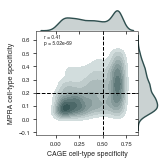

In [54]:
no_nan = all_activ[(~pd.isnull(all_activ["mpra_ts"])) & (~pd.isnull(all_activ["cage_ts"]))]
g = sns.jointplot(data=no_nan, x="cage_ts", y="mpra_ts", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, cmap=cmap, color="darkslategrey")
g.ax_joint.axhline(y=0.2, color="black", linewidth=1, linestyle="dashed")
g.ax_joint.axvline(x=0.5, color="black", linewidth=1, linestyle="dashed")
g.set_axis_labels("CAGE cell-type specificity", "MPRA cell-type specificity")
r, p = stats.spearmanr(no_nan["cage_ts"], no_nan["mpra_ts"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .8), xycoords=ax.transAxes, 
                    fontsize=5)
g.savefig("Fig_2D.pdf", bbox_inches="tight", dpi="figure")

In [55]:
def cage_v_mpra_ts(row):
    if row["cage_ts"] > 0.5 and row["mpra_ts"] > 0.2:
        return "ts in both"
    elif row["cage_ts"] > 0.5 and row["mpra_ts"] <= 0.2:
        return "ts in cage, not mpra"
    elif row["cage_ts"] <= 0.5 and row["mpra_ts"] > 0.2:
        return "ts in mpra, not cage"
    else:
        return "not ts in both"
    
no_nan["ts_status"] = no_nan.apply(cage_v_mpra_ts, axis=1)
no_nan.ts_status.value_counts()

not ts in both          692
ts in both              402
ts in mpra, not cage    310
ts in cage, not mpra    236
Name: ts_status, dtype: int64

In [56]:
tot = 692+402+310+236
upper_left = 310
upper_right = 402
lower_left = 692
lower_right = 236
print("upper left: %s" % (upper_left/tot))
print("upper right: %s" % (upper_right/tot))
print("lower left: %s" % (lower_left/tot))
print("lower right: %s" % (lower_right/tot))

upper left: 0.18902439024390244
upper right: 0.2451219512195122
lower left: 0.4219512195121951
lower right: 0.14390243902439023


In [57]:
(692+402)/(692+402+310+236)

0.6670731707317074

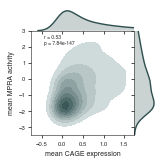

In [58]:
no_nan = all_activ[(~pd.isnull(all_activ["mpra_activ"])) & (~pd.isnull(all_activ["cage_activ"]))]
g = sns.jointplot(data=no_nan, x="cage_activ", y="mpra_activ", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, xlim=(-0.75, 1.75), ylim=(-3.5, 3), cmap=cmap, color="darkslategray")
g.set_axis_labels("mean CAGE expression", "mean MPRA activity")
r, p = stats.spearmanr(no_nan["cage_activ"], no_nan["mpra_activ"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .8), xycoords=ax.transAxes, 
                    fontsize=5)